### Load Packages and Classes

In [2]:
import pandas as pd
import numpy as np
import math
import os, sys
lib_path = os.path.abspath(os.path.join('../..', 'src')) # relative path of the source code in Box Folder 
sys.path.append(lib_path)

from PI_client2 import * # Python class to extract data from the central data infrastructure via a Web API

# libraries to plot
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('fivethirtyeight')

pc = pi_client ()

import os, sys
sys.path
print os.path.abspath(os.path.join('../..', 'src'))

/Users/decolvin/Box Sync/UCD_ECO_coding/src


## Extract Data from the PI System (Central data infrastrucure)

In [3]:
points , _ = pc.search_by_point("*ghausi*demand_kbtu*")
points

[u'Ghausi_ChilledWater_Demand_kBtu',
 u'Ghausi_ChilledWater_Demand_kBtu_counter',
 u'Ghausi_Electricity_Demand_kBtu',
 u'Ghausi_Steam_Demand_kBtu',
 u'Ghausi_Steam_Demand_kBtu_counter']

In [4]:
# inputs common to all the series
points_selected = ['Ghausi_ChilledWater_Demand_kBtu', # Chilled Water Demand
                  'aiTIT4045'] # Outside Air Temperature

# attributes for pulling data
start = "2015-01-01"
end = "*"
interval="1h"

print len(points_selected)

2


In [5]:
calculation = "calculated"
sumType="Average" 
#sumType = "PercentGood"

calculated = pc.get_stream_by_point(point_names = points_selected,
                            start=start,
                            end=end,
                            calculation=calculation,
                            interval=interval,
                            sumType=sumType,
                            label=None,
                            dataserver="s09KoOKByvc0-uxyvoTV1UfQVVRJTC1QSS1Q",
                            WebID_dic=None)
print calculated.shape

Ghausi_ChilledWater_Demand_kBtu                   1 / 2    
aiTIT4045                                         2 / 2    
(32441, 2)


In [6]:
calculated.tail()

,Ghausi_ChilledWater_Demand_kBtu,aiTIT4045
2018-09-13 16:00:00,1217.388374,82.353826
2018-09-13 17:00:00,1211.747975,81.693312
2018-09-13 18:00:00,1024.366743,77.260717
2018-09-13 19:00:00,677.694629,71.818300
2018-09-13 20:00:00,399.901809,67.995458


### Plot Data

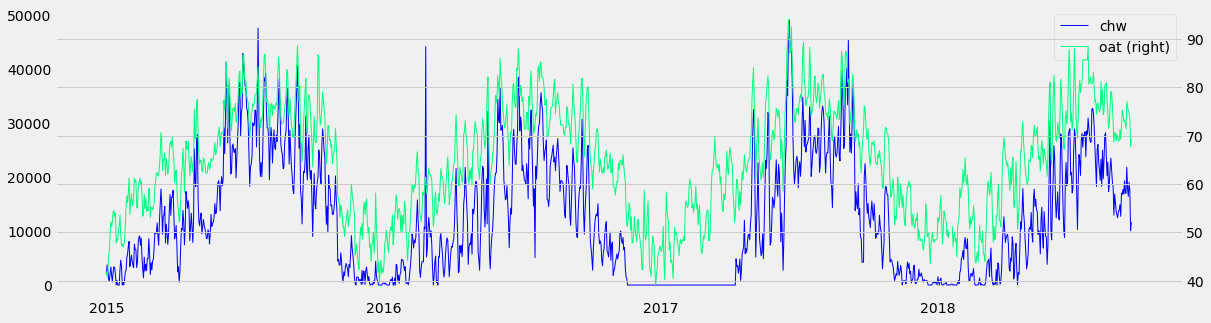

In [14]:
calculated2 = pd.DataFrame()
calculated2['chw'] = calculated['Ghausi_ChilledWater_Demand_kBtu'].resample("D").sum()
calculated2['oat'] = calculated['aiTIT4045'].resample("D").mean()
calculated2.plot(figsize=(18,5), linewidth=1, colormap='winter', secondary_y='oat')

### Data Preprocessing

In [15]:
print calculated2.shape
print
print calculated2.dtypes
print
print "Number of missing values"
print calculated2.isnull().sum()
print
#print ele.describe()
#print

#print ele.tail()

(1352, 2)

chw    float64
oat    float64
dtype: object

Number of missing values
chw    0
oat    3
dtype: int64



In [16]:
### Remove rows where delta has missing values
l1 = calculated2.loc[calculated2.oat.isnull(),:]
calculated2 = calculated2.drop(l1.index)
calculated2.shape

(1349, 2)

In [17]:
print "Number of missing values"
print calculated2.isnull().sum()

Number of missing values
chw    0
oat    0
dtype: int64


In [27]:
### Add variables 

calculated2["cdd"] = calculated2.oat - 65.0
calculated2.loc[calculated2.cdd < 0, "cdd"] = 0
calculated2["hdd"] = 65.0 - calculated2.oat
calculated2.loc[calculated2.hdd < 0, "hdd"] = 0

calculated2["cdd2"] = calculated2.cdd**2
calculated2["hdd2"] = calculated2.hdd**2

calculated2["OAT2"] = calculated2.oat**2

calculated2["Date"] = calculated2.index.date
filt = ["delta", "cdd", "hdd"]

calculated3 = calculated2

#delta3["YEAR"]=delta3.index.year
calculated3["MONTH"]= calculated3.index.month
calculated3["MONTH"] = calculated3["MONTH"].astype('category')
calculated3["TOD"] = calculated3.index.hour
calculated3["TOD"] = calculated3["TOD"].astype('category')
calculated3["DOW"]=calculated3.index.weekday
calculated3["DOW"] = calculated3["DOW"].astype('category')
#calculated3["WEEK"]=calculated3.index.week
#calculated3["WEEK"] = calculated3["WEEK"].astype('category')
#calculated3["DOY"]=calculated3.index.dayofyear
#calculated3["DOY"] = calculated3["DOY"].astype('category')

### Create dummy variables
l3 = ["MONTH","TOD","DOW"]#,"WEEK"]#,"DOY"]
calculated3 = pd.get_dummies(data=calculated3, columns=l3, drop_first=True)

### Create Weekend flag
WEEKEND= [0] * len(calculated3.DOW_5)
for i in range(0,len(calculated3.DOW_5)):
    if ((calculated3.DOW_5.iloc[i] == 1) | (calculated3.DOW_6.iloc[i] == 1)): 
        WEEKEND[i] = 1 
else: 0

calculated3["WEEKEND"] = pd.Series(WEEKEND).values
#calculated3["WEEKEND"] = calculated3["WEEKEND"].astype('category')

In [28]:
calculated3.tail()

,chw,oat,cdd,hdd,cdd2,hdd2,OAT2,Date,MONTH_2,MONTH_3,...,MONTH_10,MONTH_11,MONTH_12,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,WEEKEND
2018-09-09,16402.101333,75.043216,10.043216,0.0,100.866188,0.0,5631.484271,2018-09-09,0,0,...,0,0,0,0,0,0,0,0,1,1
2018-09-10,18958.698392,74.738757,9.738757,0.0,94.843381,0.0,5585.881744,2018-09-10,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-09-11,17518.995918,73.559695,8.559695,0.0,73.268382,0.0,5411.028760,2018-09-11,0,0,...,0,0,0,1,0,0,0,0,0,0
2018-09-12,10041.312126,67.644848,2.644848,0.0,6.995218,0.0,4575.825398,2018-09-12,0,0,...,0,0,0,0,1,0,0,0,0,0
2018-09-13,11623.687996,69.140297,4.140297,0.0,17.142057,0.0,4780.380633,2018-09-13,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
### Summary
print calculated3.dtypes
print
print calculated3.describe()

chw         float64
oat         float64
cdd         float64
hdd         float64
cdd2        float64
hdd2        float64
OAT2        float64
Date         object
MONTH_2       uint8
MONTH_3       uint8
MONTH_4       uint8
MONTH_5       uint8
MONTH_6       uint8
MONTH_7       uint8
MONTH_8       uint8
MONTH_9       uint8
MONTH_10      uint8
MONTH_11      uint8
MONTH_12      uint8
DOW_1         uint8
DOW_2         uint8
DOW_3         uint8
DOW_4         uint8
DOW_5         uint8
DOW_6         uint8
WEEKEND       int64
dtype: object

                chw          oat          cdd          hdd         cdd2  \
count   1349.000000  1349.000000  1349.000000  1349.000000  1349.000000   
mean   12275.383242    64.812752     4.685354     4.872602    61.253252   
std    10957.070258    11.352109     6.271353     6.621701   111.913386   
min        0.000000    39.106710     0.000000     0.000000     0.000000   
25%     2016.359716    55.471650     0.000000     0.000000     0.000000   
50%     9726.36

### Data exploration for outliers

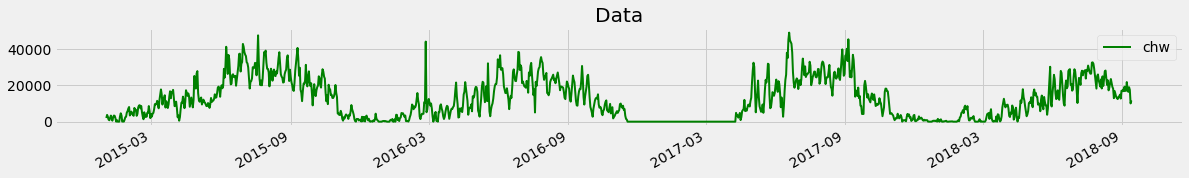

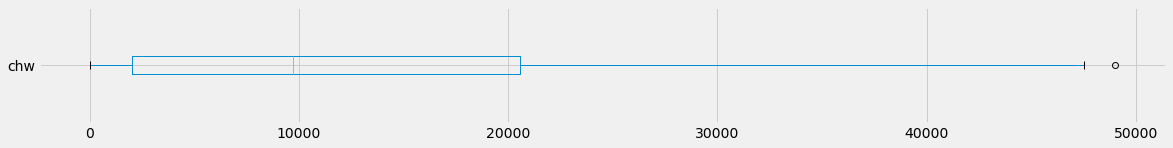

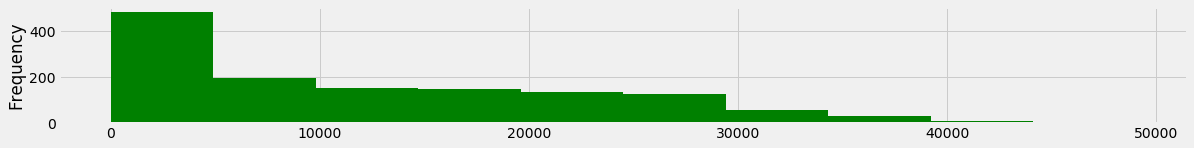

In [30]:
# Plot CHW data
plt.figure()
calculated3["chw"].plot(figsize=(18,2), title="Data",
                          linewidth=2, color='green' ,legend=True)
plt.figure()
calculated3.chw.plot(kind='box',figsize=(18,2),vert=False)

plt.figure()
calculated3.chw.plot(kind='hist',figsize=(18,2), color='green')

In [31]:
### Remove values less than 0
print calculated3.chw.quantile([0.01,0.05,0.95,0.99])
calculated3.loc[calculated3.chw<0,"deltat"] = 0

0.01        0.000000
0.05        0.000000
0.95    32024.561672
0.99    39468.487577
Name: chw, dtype: float64


Q75 = 20568
Above threshold = 48397
Below threshold = -25812


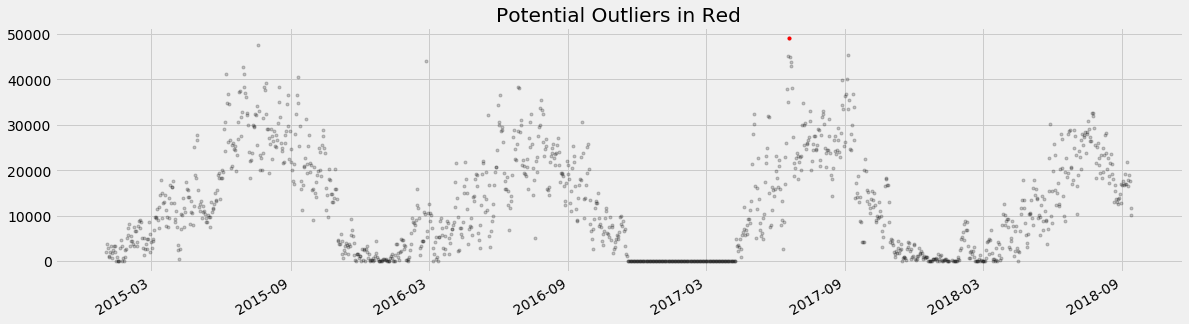

In [35]:
### Identify potential outliers
q25 = calculated3.chw.quantile(0.25)
q75 = calculated3.chw.quantile(0.75)
iqr = q75 - q25
outlier_above = q75 + iqr * 1.5
outlier_below = q25 - iqr * 1.5
print "Q75 = %.0f" %q75
print "Above threshold = %.0f" %outlier_above
print "Below threshold = %.0f" %outlier_below


calculated3.chw.plot(style=".", figsize=(18,5), c='k', alpha=0.2, title="Potential Outliers in Red")
calculated3.loc[calculated3.chw >= outlier_above,'chw'].plot(style=".", c='r')

### Check correlations

delta vs CDD = 0.92
delta vs HDD = -0.72
delta vs OAT = 0.93


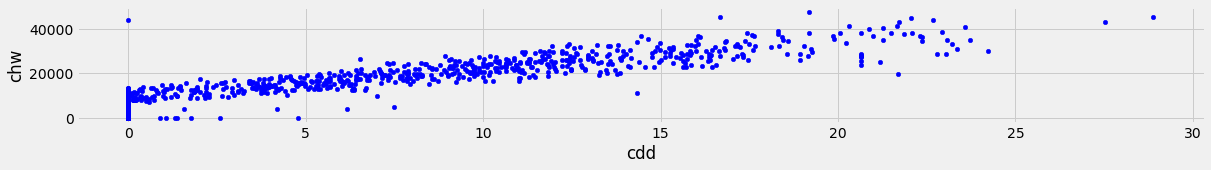

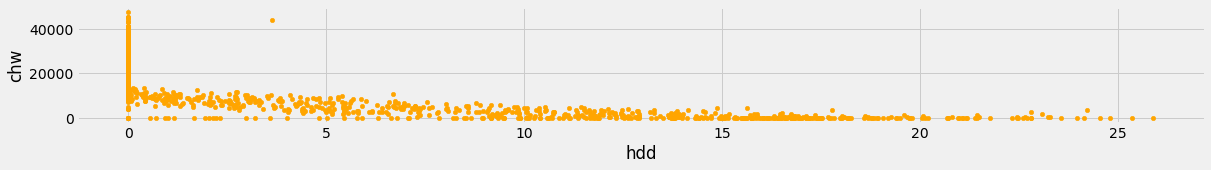

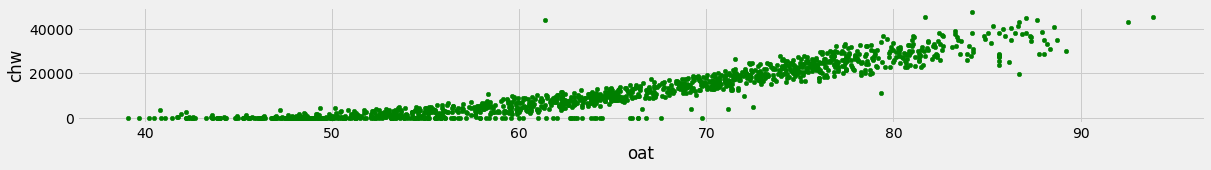

In [38]:
### Remove outliers
calculated3 = calculated3.loc[calculated3.chw < outlier_above, :]

### Correlation
calculated3.plot.scatter(x='cdd', y='chw',figsize=(18,2), color='blue')
calculated3.plot.scatter(x='hdd', y='chw',figsize=(18,2), color='orange')
calculated3.plot.scatter(x='oat', y='chw',figsize=(18,2), color='green')
print "delta vs CDD = %.2f" %calculated3.chw.corr(calculated3.cdd)
print "delta vs HDD = %.2f" %calculated3.chw.corr(calculated3.hdd)
print "delta vs OAT = %.2f" %calculated3.chw.corr(calculated3.oat)

In [40]:
calculated3.columns

Index([u'chw', u'oat', u'cdd', u'hdd', u'cdd2', u'hdd2', u'OAT2', u'Date',
       u'MONTH_2', u'MONTH_3', u'MONTH_4', u'MONTH_5', u'MONTH_6', u'MONTH_7',
       u'MONTH_8', u'MONTH_9', u'MONTH_10', u'MONTH_11', u'MONTH_12', u'DOW_1',
       u'DOW_2', u'DOW_3', u'DOW_4', u'DOW_5', u'DOW_6', u'WEEKEND',
       u'deltat'],
      dtype='object')

In [108]:
x = ['cdd', 'hdd', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'WEEKEND']

y = calculated3.chw
X = calculated3[x]

#split with time
X_train, X_test = calculated3.loc["2015-01-01":"2016-01-01",x], calculated3.loc["2016-01-01":"2017-01-01",x]
y_train, y_test = y.loc["2015-01-01":"2016-01-01"], y.loc["2016-01-01":"2017-01-01"]

In [109]:
def adj_r2_score(model,y,yhat):
        """Adjusted R square — put fitted linear model, y value, estimated y value in order
        
            Example:
            In [142]: metrics.r2_score(diabetes_y_train,yhat)
            Out[142]: 0.51222621477934993
        
            In [144]: adj_r2_score(lm,diabetes_y_train,yhat)
            Out[144]: 0.50035823946984515"""
        from sklearn import metrics
        R2 = r2_score(y,yhat)
        n = len(y)
        p = len(model.coef_)
        adj = 1-(1-R2)*(n-1)/(n-p-1)
        return adj

## Modeling

In [110]:
### Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

#X_train1 = sm.add_constant(X_train)
sm = smf.OLS(y_train, X_train)
sm_fit = sm.fit()
print sm_fit.summary() # 0.986
#print
#print r2_score(y_train,sm_fit.predict(X_train)) # 0.959
sm_rmse_train = math.sqrt(mean_squared_error(y_train, sm_fit.predict(X_train)))
print "CVRMSE = %.2f" %((math.sqrt(sum((y_train-sm_fit.predict(X_train))**2)/(len(y_train)-len(sm_fit.params)))) / y_train.mean())
#print "Train RMSE = ", sm_rmse_train

sm_pred = sm_fit.predict(X_test)
#print "R2 Test Set = ", r2_score(y_test, sm_pred) # 0.966
sm_rmse = math.sqrt(mean_squared_error(y_test, sm_pred))
#print "RMSE = ", sm_rmse
print 

vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.as_matrix(), i) for i in range(X_train.as_matrix().shape[1])]
print vif[vif["VIF Factor"] > 10]

                            OLS Regression Results                            
Dep. Variable:                    chw   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1184.
Date:                Thu, 13 Sep 2018   Prob (F-statistic):          3.47e-286
Time:                        22:25:17   Log-Likelihood:                -3405.1
No. Observations:                 366   AIC:                             6838.
Df Residuals:                     352   BIC:                             6893.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cdd         1184.1843     42.117     28.116      0.0

/Users/decolvin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Linear Regression Train Adj R2 = 0.96

Linear Regression Test Adj R2 = 0.80

CVRMSE = 0.15

RMSE = 2129.81


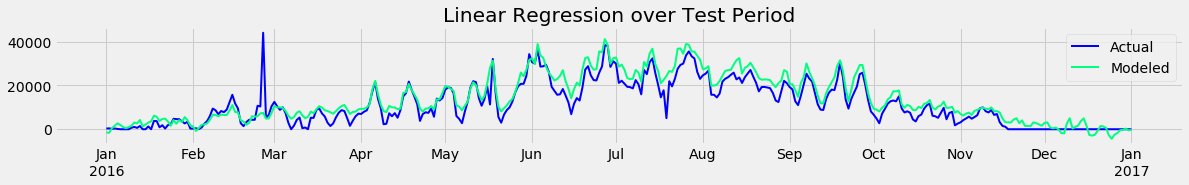

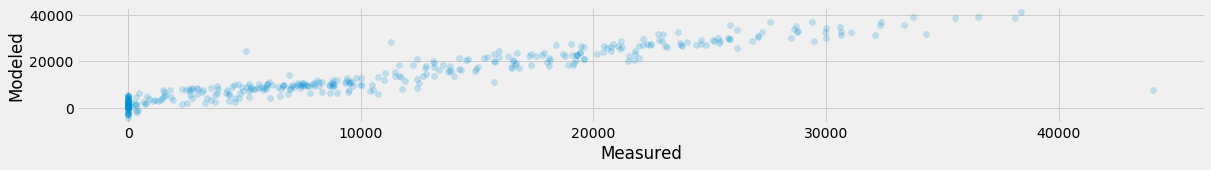

In [111]:
### Scikit Learn
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm_fit = lm.fit(y=y_train,X=X_train)
print "Linear Regression Train Adj R2 = %.2f" %adj_r2_score(lm_fit,y_train,lm.predict(X_train))
print

lm_pred = lm_fit.predict(X_test)
print "Linear Regression Test Adj R2 = %.2f" %adj_r2_score(lm_fit,y_test,lm.predict(X_test))
print
print "CVRMSE = %.2f" %(math.sqrt(mean_squared_error(y_train,lm_fit.predict(X_train)))/ y_train.mean())
lm_rmse = math.sqrt(mean_squared_error(y_test, lm_pred))
print
print "RMSE = %.2f" %(math.sqrt(mean_squared_error(y_train,lm_fit.predict(X_train))))

#y_test.plot()
#mod_lm_pred.plot()

lm_df = pd.DataFrame({"Actual":y_test,"Modeled":lm_pred})
#lm_df = pd.DataFrame({"Actual":y_train,"Pred":lm.predict(X_train)})
lm_df.plot(figsize=(18,2), linewidth=2, colormap='winter', legend=True, title="Linear Regression over Test Period")

fig, ax = plt.subplots(figsize=(18,2))
ax.scatter(lm_df.Actual, lm_df.Modeled, alpha=0.2)
ax.set_xlabel('Measured')
ax.set_ylabel('Modeled')
plt.show()

# Savings

Savings over last year = $18251


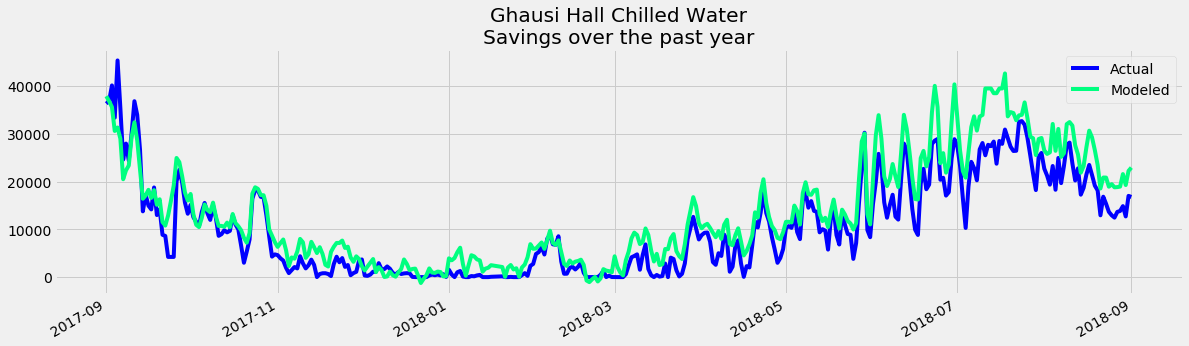

In [112]:
y_post = calculated3.loc["2017-09-01":"2018-09-01", 'chw']
pred_post = lm_fit.predict(calculated3.loc["2017-09-01":"2018-09-01", x])

df_post = pd.DataFrame({"Actual":y_post, "Modeled":pred_post})

df_post.plot(figsize=(18,5), colormap='winter', title="Ghausi Hall Chilled Water\nSavings over the past year")

print("Savings over last year = $%i" %((df_post.Modeled.sum() - df_post.Actual.sum()) * 0.0157))